In [1]:
# ========================
# 0. IMPORTS
# ========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Dense, LSTM, RepeatVector, TimeDistributed)
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.client import device_lib

import os

# ========================
# 1. CONFIGURATION
# ========================
INPUT_STEPS = 10
FORECAST_STEPS = 10
TEST_RATIO = 0.3

# Tuning parameters
EPOCHS_LIST = [40]
BATCH_SIZES = [1024]

WINDOW_SIZE_SIMULATION = 10  # 6h window
THRESHOLD_PERCENTILE = 90

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ========================
# 2. DEVICE SETUP
# ========================
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("✅ GPU is available and will be used.")
    except RuntimeError as e:
        print(e)
else:
    print("⚠️ No GPU detected, running on CPU.")

# ========================
# 3. LOAD AND PREPROCESS DATA
# ========================
file_path = '../../data/original_labeled_dataset.csv'
df = pd.read_csv(file_path, delimiter=',')
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
df.set_index('DateTime', inplace=True)

df.drop(columns=['labels'], inplace=True)

# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)
df_scaled = pd.DataFrame(scaled_data, index=df.index, columns=df.columns).astype(np.float32)

print(f"✅ Scaled dataset shape: {df_scaled.shape}")


file_path2 = '../../data/rfcc_second_longest_active_window.csv'
df_test = pd.read_csv(file_path2, delimiter=',')
df_test['DateTime'] = pd.to_datetime(df_test['DateTime'], errors='coerce')
df_test.set_index('DateTime', inplace=True)


# Normalize
scaler = MinMaxScaler()
scaled_test_data = scaler.fit_transform(df_test.values)
df_test_scaled = pd.DataFrame(scaled_test_data, index=df_test.index, columns=df_test.columns).astype(np.float32)

print(f"✅ Scaled dataset shape: {df_test_scaled.shape}")




# ========================
# 4. SEQUENTIAL TRAIN/TEST SPLIT
# ========================
#split_idx = int((1 - TEST_RATIO) * len(df_scaled))
#train_data = df_scaled.iloc[:split_idx]
#test_data = df_scaled.iloc[split_idx:]
train_data = df_scaled
test_data  = df_test_scaled
print(f"✅ Training samples: {len(train_data)}, Testing samples: {len(test_data)}")

# ========================
# 5. CREATE SEQUENCES
# ========================
def create_sequences(data, input_steps, forecast_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - forecast_steps):
        X.append(data[i:i+input_steps])
        y.append(data[i+input_steps:i+input_steps+forecast_steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X_train_seq, y_train_seq = create_sequences(train_data.values, INPUT_STEPS, FORECAST_STEPS)
X_test_seq, y_test_seq = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

print(f"✅ Training sequences: {X_train_seq.shape}, Testing sequences: {X_test_seq.shape}")

# ========================
# 6. BUILD LSTM SEQ2SEQ MODEL
# ========================
def build_lstm_seq2seq(input_steps, forecast_steps, input_dim, units=128):
    inputs = Input(shape=(input_steps, input_dim))
    encoded = LSTM(units)(inputs)
    repeated = RepeatVector(forecast_steps)(encoded)
    decoded = LSTM(units, return_sequences=True)(repeated)
    outputs = TimeDistributed(Dense(input_dim))(decoded)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    return model

# ========================
# 7. TRAINING + TUNING
# ========================
best_val_rmse = np.inf
best_model = None
history_records = []

for epochs in EPOCHS_LIST:
    for batch_size in BATCH_SIZES:
        print(f"\n🔵 Training LSTM Seq2Seq with epochs={epochs}, batch_size={batch_size}")
        
        model = build_lstm_seq2seq(INPUT_STEPS, FORECAST_STEPS, X_train_seq.shape[2])
        es = EarlyStopping(patience=5, restore_best_weights=True)

        history = model.fit(X_train_seq, y_train_seq,
                            validation_split=0.1,
                            epochs=epochs,
                            batch_size=batch_size,
                            callbacks=[es],
                            verbose=1,
                            shuffle=False)
        
        val_preds = model.predict(X_test_seq, batch_size=batch_size)
        val_rmse = np.sqrt(mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1)))
        val_mae = mean_absolute_error(y_test_seq.reshape(-1), val_preds.reshape(-1))
        val_mse = mean_squared_error(y_test_seq.reshape(-1), val_preds.reshape(-1))

        print(f"✅ Validation RMSE: {val_rmse:.5f},MSE: {val_mse:.5f}, MAE: {val_mae:.5f}")


        history_records.append({
            "epochs": epochs,
            "batch_size": batch_size,
            "val_rmse": val_rmse,
            "val_mse": val_mse,
            "val_mae": val_mae
            
        })

        if val_rmse < best_val_rmse:
            best_val_rmse = val_rmse
            best_model = model

# Save tuning history
history_df = pd.DataFrame(history_records)
history_df.to_csv("lstm_seq2seq_tuning_history.csv", index=False)
print("\n📋 Tuning Results Summary:")
print(history_df)

# Save best model
best_model.save("best_lstm_seq2seq_forecaster.keras")
print("\n✅ Best LSTM Seq2Seq model saved.")


✅ GPU is available and will be used.
✅ Scaled dataset shape: (18652, 26)
✅ Scaled dataset shape: (12131, 26)
✅ Training samples: 18652, Testing samples: 12131
✅ Training sequences: (18632, 10, 26), Testing sequences: (12111, 10, 26)

🔵 Training LSTM Seq2Seq with epochs=40, batch_size=1024
Epoch 1/40
17/17 [==============================] - 18s 187ms/step - loss: 0.1256 - val_loss: 0.0561
Epoch 2/40
17/17 [==============================] - 1s 38ms/step - loss: 0.0560 - val_loss: 0.0533
Epoch 3/40
17/17 [==============================] - 1s 37ms/step - loss: 0.0353 - val_loss: 0.0384
Epoch 4/40
17/17 [==============================] - 1s 35ms/step - loss: 0.0284 - val_loss: 0.0364
Epoch 5/40
17/17 [==============================] - 1s 35ms/step - loss: 0.0230 - val_loss: 0.0293
Epoch 6/40
17/17 [==============================] - 1s 36ms/step - loss: 0.0210 - val_loss: 0.0266
Epoch 7/40
17/17 [==============================] - 1s 35ms/step - loss: 0.0192 - val_loss: 0.0256
Epoch 8/40
17/1


✅ Real-time simulation complete.

📈 Forecasting Evaluation on Test:
RMSE: 0.26938
MAE:  0.19120


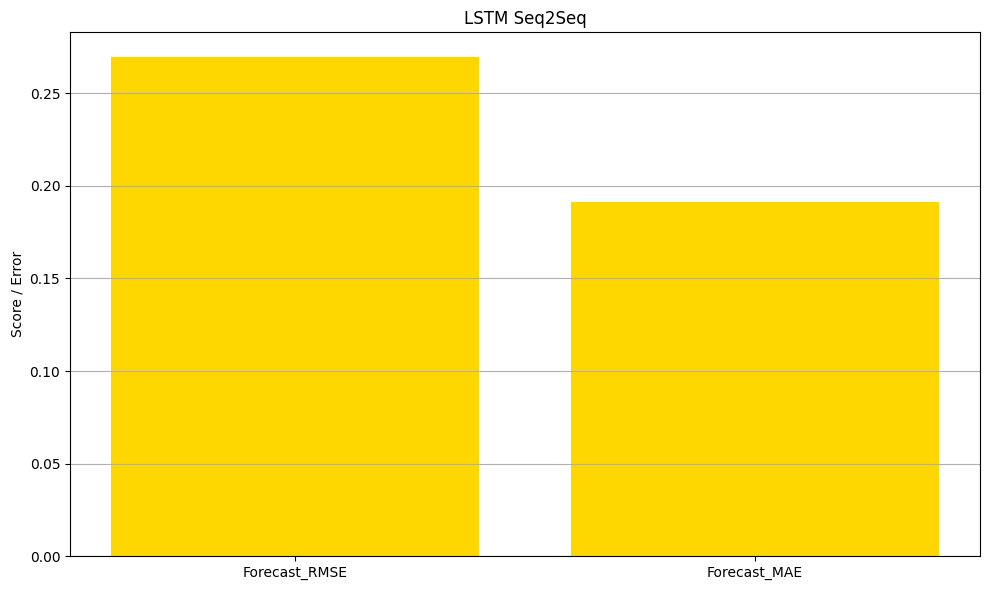

In [2]:
# ========================
# 9. REAL-TIME SIMULATION ON TEST SET
# ========================

simulation_X, simulation_y = create_sequences(test_data.values, INPUT_STEPS, FORECAST_STEPS)

forecast_list = []
true_windows = []

for i in range(0, len(simulation_X), WINDOW_SIZE_SIMULATION):
    window_X = simulation_X[i:i+1]
    window_y_true = simulation_y[i]

    y_pred_future = best_model.predict(window_X,batch_size=1024, verbose=0)[0]

    forecast_list.append(y_pred_future)
    true_windows.append(window_y_true)

print("\n✅ Real-time simulation complete.")

# ========================
# 10. EVALUATION
# ========================

# Forecasting metrics
y_pred_all = np.vstack(forecast_list)
y_true_all = np.vstack(true_windows)

forecast_rmse = np.sqrt(mean_squared_error(y_true_all.reshape(-1), y_pred_all.reshape(-1)))
forecast_mae = mean_absolute_error(y_true_all.reshape(-1), y_pred_all.reshape(-1))

print(f"\n📈 Forecasting Evaluation on Test:")
print(f"RMSE: {forecast_rmse:.5f}")
print(f"MAE:  {forecast_mae:.5f}")

# ========================
# 11. SAVE METRICS
# ========================

metrics_results = {
    "Model": "LSTM Seq2Seq",
    "Forecast_RMSE": forecast_rmse,
    "Forecast_MAE": forecast_mae
}

metrics_df = pd.DataFrame([metrics_results])

# ========================
# 12. PLOTS
# ========================

# Plot Metrics
metric_names = ["Forecast_RMSE", "Forecast_MAE"]
metric_values = [forecast_rmse, forecast_mae]

plt.figure(figsize=(10,6))
plt.bar(metric_names, metric_values, color='gold')
plt.title("LSTM Seq2Seq")
plt.ylabel("Score / Error")
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("metrics_bar_chart_lstm_seq2seq.png")
plt.show()
